In [1]:
import threading
import queue
import time
start_time = time.time()
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from MultiTimeframeCandleManager import *
from datetime import datetime, timedelta
from collections import deque
import numpy as np
from tqdm import tqdm
import copy
import tensorflow as tf
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (
        Input, Lambda, Concatenate, Dense, Embedding, Dropout, LSTM, 
        MultiHeadAttention, LayerNormalization, LeakyReLU, GlobalAveragePooling1D, Add
    )
from tensorflow.keras import backend as K

#from tensorflow.keras import mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

start_time = time.time()

tpu_mode = False

gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

2025-08-14 01:18:42.518558: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 01:18:42.547117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-14 01:18:43.109683: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("CUDA version TF was built with:", tf.sysconfig.get_build_info()["cuda_version"])
print("cuDNN version TF was built with:", tf.sysconfig.get_build_info()["cudnn_version"])

TF version: 2.20.0-dev0+selfbuilt
CUDA version TF was built with: 12.8.1
cuDNN version TF was built with: 9


In [3]:
def make_model():
    l = 480
    
    def process_chart_with_time_position(chart_input, name):
        # Extract OHLC and clip values
        ohlc = Lambda(lambda x: tf.clip_by_value(x[:, :, :4], -1000.0, 1000.0),
                      name=f'{name}_clip_ohlc')(chart_input)
        
        # Extract time column and cast to int
        t = Lambda(lambda x: x[:, :, 4:5], name=f'{name}_extract_time')(chart_input)
        t_int = Lambda(lambda x: tf.cast(tf.squeeze(x, axis=-1), tf.int32),
                       name=f'{name}_cast_time')(t)
    
        # Time embedding
        time_embed_layer = Embedding(input_dim=24*60, output_dim=8, name=f'{name}_time_embed')
        t_embed = time_embed_layer(t_int)
    
        # Position embedding (based on sequence length from chart_input shape)
        seq_length = chart_input.shape[1]
        positions = tf.range(seq_length)
        position_embed = Embedding(input_dim=seq_length, output_dim=8,
                                   name=f'{name}_pos_embed')(positions)

        # Add batch dimension so shape matches (batch, seq_length, 8)
        position_embed = tf.expand_dims(position_embed, axis=0)  # (1, 480, 8)
        position_embed = Lambda(lambda x: K.tile(x[0], [K.shape(x[1])[0], 1, 1]))([position_embed, chart_input])
        
        # Combine time and position embeddings
        enhanced_time = Add(name=f'{name}_add_time_pos')([t_embed, position_embed])
    
        # Concatenate OHLC(4) + enhanced_time(8) → 12 dims
        return Concatenate(name=f'{name}_concat')([ohlc, enhanced_time])

    
    def relational_attention_block(x, num_heads=8, key_dim=64, name_prefix=""):
        """Self-attention to capture relationships between candles"""
        # Multi-head self-attention
        attention_out = MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=key_dim,
            name=f'{name_prefix}_attention'
        )(x, x)
        
        # Residual connection + layer norm
        x_normed = LayerNormalization(name=f'{name_prefix}_norm1')(x + attention_out)
        
        # Feed-forward network
        ff_dim = x.shape[-1] * 2
        ff = Dense(ff_dim, activation='gelu', name=f'{name_prefix}_ff1')(x_normed)
        ff = Dense(x.shape[-1], name=f'{name_prefix}_ff2')(ff)
        
        # Second residual connection + layer norm
        output = LayerNormalization(name=f'{name_prefix}_norm2')(x_normed + ff)
        
        return output
    
    def process_timeframe_with_attention(chart_input, pdas_repeated, name):
        """Process each timeframe with attention mechanisms"""
        # Concatenate chart with PDAs
        x = Concatenate(axis=-1, name=f'{name}_concat_pdas')([chart_input, pdas_repeated])
        
        # Initial feature extraction - reduce dimensions gradually
        x = Dense(512, name=f'{name}_dense1')(x)
        x = LayerNormalization(name=f'{name}_norm_init')(x)
        x = LeakyReLU(0.1, name=f'{name}_relu1')(x)
        x = Dropout(0.1, name=f'{name}_dropout1')(x)
        
        x = Dense(512, name=f'{name}_dense2')(x)
        x = LayerNormalization(name=f'{name}_norm2')(x)
        x = LeakyReLU(0.1, name=f'{name}_relu2')(x)
        
        # Apply attention blocks to capture relational patterns
        x = relational_attention_block(x, num_heads=24, key_dim=256, name_prefix=f'{name}_attn1')
        x = relational_attention_block(x, num_heads=24, key_dim=256, name_prefix=f'{name}_attn2')
        x = relational_attention_block(x, num_heads=24, key_dim=256, name_prefix=f'{name}_attn3')
        x = relational_attention_block(x, num_heads=24, key_dim=256, name_prefix=f'{name}_attn4')
        x = relational_attention_block(x, num_heads=24, key_dim=256, name_prefix=f'{name}_attn5')
        x = relational_attention_block(x, num_heads=24, key_dim=256, name_prefix=f'{name}_attn6')
        
        # Final sequence compression with LSTM (single layer is often enough after attention)
        x = LSTM(256, return_sequences=False, name=f'{name}_lstm')(x)
        
        return x
    
    
    ### Inputs
    input_chart_m15 = Input(shape=(l,5), name='chart_m15')
    input_chart_m5  = Input(shape=(l,5), name='chart_m5')
    input_chart_m1  = Input(shape=(l,5), name='chart_m1')
    
    pdas = Input(shape=(3*3 + 3*3 + 1 + 12*5 + 5*3,), name='pdas')
    pdas = Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0), name='clip_pdas')(pdas)
    
    #minutes = Input(shape=(1,), name='minutes')
    
    ### Process each chart with enhanced time/position embeddings
    chart_m15 = process_chart_with_time_position(input_chart_m15, 'm15')
    chart_m5  = process_chart_with_time_position(input_chart_m5, 'm5')
    chart_m1  = process_chart_with_time_position(input_chart_m1, 'm1')
    
    # Repeat PDAs for concatenation
    pdas_repeated = Lambda(
        lambda inputs: tf.repeat(tf.expand_dims(inputs, axis=1), repeats=l, axis=1),
        name='repeat_pdas'
    )(pdas)
    
    ### Process each timeframe with attention
    m15_features = process_timeframe_with_attention(chart_m15, pdas_repeated, 'm15')
    m5_features = process_timeframe_with_attention(chart_m5, pdas_repeated, 'm5') 
    m1_features = process_timeframe_with_attention(chart_m1, pdas_repeated, 'm1')

    ### Final combination and prediction
    # Combine all enhanced features with original PDAs
    c = Concatenate(name='final_concat')([pdas, m1_features, m5_features, m15_features])
    
    # Final prediction layers - smaller than before since attention does heavy lifting
    d = Dense(2048, name='pred_dense1')(c)
    d = LayerNormalization(name='pred_norm1')(d)
    d = LeakyReLU(0.1, name='pred_relu1')(d)
    d = Dropout(0.1, name='pred_dropout1')(d)
    
    d = Dense(1024, name='pred_dense2')(d)
    d = LayerNormalization(name='pred_norm2')(d)
    d = LeakyReLU(0.1, name='pred_relu2')(d)
    d = Dropout(0.1, name='pred_dropout2')(d)
    
    d = Dense(512, name='pred_dense3')(d)
    d = LayerNormalization(name='pred_norm3')(d)
    d = LeakyReLU(0.1, name='pred_relu3')(d)
    
    # Stabilization layer before final prediction
    d = Dense(256, activation='tanh', name='pre_softmax_tanh')(d)
    
    # Final prediction
    output = Dense(3, activation="softmax", dtype="float32", name='output')(d)
    
    model = tf.keras.Model(inputs=[input_chart_m15, input_chart_m5, input_chart_m1, pdas], 
                  outputs=output)
    
    return model

In [4]:
if tpu_mode:
        cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
        tf.config.experimental_connect_to_cluster(cluster_resolver)
        tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
        strategy = tf.distribute.TPUStrategy(cluster_resolver)
        

In [5]:
lr = 0.00001

if tpu_mode:
    with strategy.scope():
        model = make_model()
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
else:
    model = make_model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    
model.summary()

I0000 00:00:1755134323.637002   24524 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29815 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5090, pci bus id: 0000:01:00.0, compute capability: 12.0
E0000 00:00:1755134323.962292   24611 ptx_compiler_helpers.cc:88] *** WARNING *** Invoking ptxas with version 12.0.140, which corresponds to a CUDA version <=12.6.2. CUDA versions 12.x.y up to and including 12.6.2 miscompile certain edge cases around clamping.
Please upgrade to CUDA 12.6.3 or newer.
2025-08-14 01:18:43.964047: W external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:237] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 12.0
2025-08-14 01:18:43.964060: W external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:240] Used ptxas at /usr/bin/ptxas
2025-08-14 01:18:43.964114: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:188] Failed to compile genera

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ chart_m1            │ (None, 480, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chart_m5            │ (None, 480, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chart_m15           │ (None, 480, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m1_extract_time     │ (None, 480, 1)    │          0 │ chart_m1[1][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m5_extract_time     │ (None, 480, 1)    │          0 │ chart_m5[1][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m15_extract_time    │ (None, 480, 1)    │          0 │ chart_m15[1][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m1_cast_time        │ (None, 480)       │          0 │ m1_extract_time[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m5_cast_time        │ (None, 480)       │          0 │ m5_extract_time[… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m15_cast_time       │ (None, 480)       │          0 │ m15_extract_time… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m1_time_embed       │ (None, 480, 8)    │     11,520 │ m1_cast_time[1][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 480, 8)    │          0 │ chart_m1[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m5_time_embed       │ (None, 480, 8)    │     11,520 │ m5_cast_time[1][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 480, 8)    │          0 │ chart_m5[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m15_time_embed      │ (None, 480, 8)    │     11,520 │ m15_cast_time[1]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 480, 8)    │          0 │ chart_m15[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keras_tensor_2CLONE │ (None, 94)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m1_clip_ohlc        │ (None, 480, 4)    │          0 │ chart_m1[1][0]    │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ m1_add_time_pos     │ (None, 480, 8)    │          0 │ m1_time_embed[1]

 Total params: 20,923,395 (79.82 MB)

 Trainable params: 20,923,395 (79.82 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
train_data = []

data_dirs = [
    "."
]
data_files= []
for d in data_dirs:
    subfiles = os.listdir(d)
    for f in subfiles:
        if "_train_" in f and "_2" in f:
            path = os.path.join(d,f)
            print(path)
            data_files.append(path)

data_index = 0
def load_new_data():
    global data_index
    data_index+=1
    if data_index >= len(data_files):
        data_index = 0

    file = data_files[data_index]
    data = obj_load(file)
    return data
    

data_queue = queue.Queue(maxsize=1)

def data_loader():
    """Background thread that continuously loads data into the queue."""
    while True:
        # Only load new data if there is room in the queue.
        if data_queue.qsize() < data_queue.maxsize:
            new_data = load_new_data()
            print("new data loaded!")
            random.shuffle(new_data)
            data_queue.put(new_data)
        else:
            # Sleep briefly to avoid busy waiting.
            time.sleep(1)

# Start the data loader thread as a daemon so it exits when the main program ends.
if not tpu_mode:
    
    # info about class distribution
    c0 = 0
    c1 = 0
    c2 = 0
    print("finding data distribution...")
    for file in tqdm(data_files):
        data = obj_load(file)
        for x,y in data:
            if y == -1:
                c0+=1
            if y == 1:
                c1+=1
            if y == 0:
                c2+=1
                    
    loader_thread = threading.Thread(target=data_loader, daemon=True)
    loader_thread.daemon = True
    loader_thread.start()


# or load all data at once if it fits in memory
else:
    train_data=[]
    for file in data_files:
                    data = obj_load(file)
                    train_data.extend(data)
                    #break

    random.shuffle(train_data)
    
   # info about class distribution
    c0 = 0
    c1 = 0
    c2 = 0
    print("info about y distribution:")
    for x,y in train_data:
            if y == -1:
                c0+=1
            if y == 1:
                c1+=1
            if y == 0:
                c2+=1
print("raw distribution:", c0,c1,c2)
l = c0+c1+c2
print("relative distribution:", c0/l,c1/l,c2/l)

./NQ_2_train_49
./NQ_2_train_41
./NQ_2_train_48
./NQ_2_train_28
./NQ_2_train_56
./NQ_2_train_20
./NQ_2_train_43
./NQ_2_train_57
./NQ_2_train_31
./NQ_2_train_47
./NQ_2_train_30
./NQ_2_train_54
./NQ_2_train_38
./NQ_2_train_22
./NQ_2_train_13
./NQ_2_train_42
./NQ_2_train_65
./NQ_2_train_51
./NQ_2_train_17
./NQ_2_train_2
./NQ_2_train_23
./NQ_2_train_32
./NQ_2_train_60
./NQ_2_train_3
./NQ_2_train_44
./NQ_2_train_45
./NQ_2_train_26
./NQ_2_train_29
./NQ_2_train_67
./NQ_2_train_14
./NQ_2_train_27
./NQ_2_train_68
./NQ_2_train_55
./NQ_2_train_52
./NQ_2_train_4
./NQ_2_train_37
./NQ_2_train_10
./NQ_2_train_21
./NQ_2_train_9
./NQ_2_train_19
./NQ_2_train_7
./NQ_2_train_24
./NQ_2_train_18
./NQ_2_train_0
./NQ_2_train_61
./NQ_2_train_33
./NQ_2_train_50
./NQ_2_train_12
./NQ_2_train_36
./NQ_2_train_5
./NQ_2_train_40
./NQ_2_train_6
./NQ_2_train_62
./NQ_2_train_63
./NQ_2_train_46
./NQ_2_train_8
./NQ_2_train_15
./NQ_2_train_64
./NQ_2_train_58
./NQ_2_train_53
./NQ_2_train_34
./NQ_2_train_39
./NQ_2_train_59
.

  0%|          | 0/69 [00:00<?, ?it/s]

loading ./NQ_2_train_49


  1%|▏         | 1/69 [00:00<00:58,  1.16it/s]

loading ./NQ_2_train_41


  3%|▎         | 2/69 [00:01<00:49,  1.34it/s]

loading ./NQ_2_train_48


  4%|▍         | 3/69 [00:01<00:39,  1.68it/s]

loading ./NQ_2_train_28


  6%|▌         | 4/69 [00:02<00:34,  1.87it/s]

loading ./NQ_2_train_56


  7%|▋         | 5/69 [00:02<00:32,  1.98it/s]

loading ./NQ_2_train_20


  9%|▊         | 6/69 [00:03<00:31,  2.01it/s]

loading ./NQ_2_train_43


 10%|█         | 7/69 [00:03<00:29,  2.08it/s]

loading ./NQ_2_train_57


 12%|█▏        | 8/69 [00:04<00:28,  2.13it/s]

loading ./NQ_2_train_31


 13%|█▎        | 9/69 [00:04<00:27,  2.18it/s]

loading ./NQ_2_train_47


 14%|█▍        | 10/69 [00:05<00:26,  2.20it/s]

loading ./NQ_2_train_30


 16%|█▌        | 11/69 [00:05<00:26,  2.21it/s]

loading ./NQ_2_train_54


 17%|█▋        | 12/69 [00:05<00:25,  2.22it/s]

loading ./NQ_2_train_38


 19%|█▉        | 13/69 [00:06<00:25,  2.19it/s]

loading ./NQ_2_train_22


 20%|██        | 14/69 [00:06<00:25,  2.17it/s]

loading ./NQ_2_train_13


 22%|██▏       | 15/69 [00:07<00:24,  2.19it/s]

loading ./NQ_2_train_42


 23%|██▎       | 16/69 [00:07<00:24,  2.20it/s]

loading ./NQ_2_train_65


 25%|██▍       | 17/69 [00:08<00:27,  1.91it/s]

loading ./NQ_2_train_51


 26%|██▌       | 18/69 [00:08<00:25,  1.99it/s]

loading ./NQ_2_train_17


 28%|██▊       | 19/69 [00:09<00:24,  2.04it/s]

loading ./NQ_2_train_2


 29%|██▉       | 20/69 [00:09<00:23,  2.10it/s]

loading ./NQ_2_train_23


 30%|███       | 21/69 [00:10<00:22,  2.11it/s]

loading ./NQ_2_train_32


 32%|███▏      | 22/69 [00:10<00:22,  2.07it/s]

loading ./NQ_2_train_60


 33%|███▎      | 23/69 [00:11<00:25,  1.81it/s]

loading ./NQ_2_train_3


 35%|███▍      | 24/69 [00:11<00:23,  1.93it/s]

loading ./NQ_2_train_44


 36%|███▌      | 25/69 [00:12<00:22,  1.99it/s]

loading ./NQ_2_train_45


 38%|███▊      | 26/69 [00:13<00:23,  1.80it/s]

loading ./NQ_2_train_26


 39%|███▉      | 27/69 [00:13<00:25,  1.67it/s]

loading ./NQ_2_train_29


 41%|████      | 28/69 [00:14<00:25,  1.60it/s]

loading ./NQ_2_train_67


 42%|████▏     | 29/69 [00:15<00:25,  1.56it/s]

loading ./NQ_2_train_14


 43%|████▎     | 30/69 [00:15<00:25,  1.51it/s]

loading ./NQ_2_train_27


 45%|████▍     | 31/69 [00:16<00:25,  1.51it/s]

loading ./NQ_2_train_68


 46%|████▋     | 32/69 [00:16<00:21,  1.72it/s]

loading ./NQ_2_train_55


 48%|████▊     | 33/69 [00:17<00:22,  1.62it/s]

loading ./NQ_2_train_52


 49%|████▉     | 34/69 [00:18<00:21,  1.60it/s]

loading ./NQ_2_train_4


 51%|█████     | 35/69 [00:18<00:19,  1.73it/s]

loading ./NQ_2_train_37


 52%|█████▏    | 36/69 [00:19<00:19,  1.66it/s]

loading ./NQ_2_train_10


 54%|█████▎    | 37/69 [00:20<00:20,  1.58it/s]

loading ./NQ_2_train_21


 55%|█████▌    | 38/69 [00:20<00:20,  1.53it/s]

loading ./NQ_2_train_9


 57%|█████▋    | 39/69 [00:21<00:19,  1.53it/s]

loading ./NQ_2_train_19


 58%|█████▊    | 40/69 [00:22<00:19,  1.51it/s]

loading ./NQ_2_train_7


 59%|█████▉    | 41/69 [00:22<00:18,  1.48it/s]

loading ./NQ_2_train_24


 61%|██████    | 42/69 [00:23<00:18,  1.49it/s]

loading ./NQ_2_train_18


 62%|██████▏   | 43/69 [00:24<00:17,  1.48it/s]

loading ./NQ_2_train_0


 64%|██████▍   | 44/69 [00:24<00:15,  1.65it/s]

loading ./NQ_2_train_61


 65%|██████▌   | 45/69 [00:25<00:14,  1.60it/s]

loading ./NQ_2_train_33


 67%|██████▋   | 46/69 [00:26<00:14,  1.53it/s]

loading ./NQ_2_train_50


 68%|██████▊   | 47/69 [00:26<00:14,  1.53it/s]

loading ./NQ_2_train_12


 70%|██████▉   | 48/69 [00:27<00:13,  1.55it/s]

loading ./NQ_2_train_36


 71%|███████   | 49/69 [00:28<00:13,  1.51it/s]

loading ./NQ_2_train_5


 72%|███████▏  | 50/69 [00:28<00:11,  1.68it/s]

loading ./NQ_2_train_40


 74%|███████▍  | 51/69 [00:29<00:11,  1.60it/s]

loading ./NQ_2_train_6


 75%|███████▌  | 52/69 [00:29<00:10,  1.57it/s]

loading ./NQ_2_train_62


 77%|███████▋  | 53/69 [00:30<00:10,  1.54it/s]

loading ./NQ_2_train_63


 78%|███████▊  | 54/69 [00:31<00:09,  1.53it/s]

loading ./NQ_2_train_46


 80%|███████▉  | 55/69 [00:31<00:09,  1.50it/s]

loading ./NQ_2_train_8


 81%|████████  | 56/69 [00:32<00:08,  1.53it/s]

loading ./NQ_2_train_15


 83%|████████▎ | 57/69 [00:33<00:07,  1.53it/s]

loading ./NQ_2_train_64


 84%|████████▍ | 58/69 [00:33<00:07,  1.52it/s]

loading ./NQ_2_train_58


 86%|████████▌ | 59/69 [00:34<00:06,  1.47it/s]

loading ./NQ_2_train_53


 87%|████████▋ | 60/69 [00:35<00:06,  1.48it/s]

loading ./NQ_2_train_34


 88%|████████▊ | 61/69 [00:35<00:05,  1.49it/s]

loading ./NQ_2_train_39


 90%|████████▉ | 62/69 [00:36<00:04,  1.50it/s]

loading ./NQ_2_train_59


 91%|█████████▏| 63/69 [00:37<00:04,  1.48it/s]

loading ./NQ_2_train_66


 93%|█████████▎| 64/69 [00:37<00:03,  1.49it/s]

loading ./NQ_2_train_25


 94%|█████████▍| 65/69 [00:38<00:02,  1.49it/s]

loading ./NQ_2_train_1


 96%|█████████▌| 66/69 [00:39<00:01,  1.62it/s]

loading ./NQ_2_train_16


 97%|█████████▋| 67/69 [00:39<00:01,  1.59it/s]

loading ./NQ_2_train_35


 99%|█████████▊| 68/69 [00:40<00:00,  1.56it/s]

loading ./NQ_2_train_11


100%|██████████| 69/69 [00:41<00:00,  1.68it/s]

loadingraw distribution: 302217 276050 2847715
 ./NQ_2_train_41
relative distribution: 0.08821324805559398 0.0805754379328321 0.8312113140115739


new data loaded!
loading ./NQ_2_train_48
new data loaded!
loading ./NQ_2_train_28
new data loaded!
loading ./NQ_2_train_56
new data loaded!
loading ./NQ_2_train_20
new data loaded!
loading ./NQ_2_train_43
new data loaded!
loading ./NQ_2_train_57
new data loaded!
loading ./NQ_2_train_31
new data loaded!
loading ./NQ_2_train_47
new data loaded!
loading ./NQ_2_train_30
new data loaded!
loading ./NQ_2_train_54
new data loaded!
loading ./NQ_2_train_38
new data loaded!
loading ./NQ_2_train_22
new data loaded!
loading ./NQ_2_train_13
new data loaded!
loading ./NQ_2_train_42
new data loaded!
loading ./NQ_2_train_65
new data loaded!
loading ./NQ_2_train_51
new data loaded!
loading ./NQ_2_train_17
new data loaded!
loading ./NQ_2_train_2
new data loaded!
loading ./NQ_2_train_23
new data loaded!
loading ./NQ_2_train_32
new data loaded!


In [7]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [8]:
try:
    model.load_weights("model.weights.h5")
    print("weights loaded!")
except Exception as e:
    print(e)
    print("no weights loaded")

A total of 126 objects could not be loaded. Example error message for object <EinsumDense name=key, built=True>:

Layer 'key' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDe

In [9]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)

 
class_counts = np.array([c0, c1, c2])
class_weights = class_counts.sum() / (len(class_counts) * class_counts)
class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
print("weights:", class_weights_tensor)


tf.function(jit_compile=True) # my gpu does not support this
def tstep(data):
    x, y = data

    with tf.GradientTape() as t:
        model_return = model(x, training=True)
        #print(y, model_return)
        loss = loss_fn(y, model_return)
        #print(loss)
        

        # Apply class weights
        sample_weights = tf.reduce_sum(y * class_weights_tensor, axis=-1)  # Select the correct weight for each sample
        loss = loss * sample_weights  # Multiply loss by sample weights

        loss = tf.reduce_mean(loss)

        
        #if loss > 10:
        #    loss *= 0.1  # Scale down the loss if it's greater than 10, probably data point error

    predicted_class = tf.argmax(model_return, axis=-1)
    true_class = tf.argmax(y, axis=-1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_class, true_class), tf.float32))
            
    
    gradient = t.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    return loss, accuracy


batch_size = 32

def get_data(_):
    global train_data

    while len(train_data) < 10000:
        if not data_queue.empty():
            new_data = data_queue.get(timeout=1)  # wait up to 1 second for data
            train_data.extend(new_data)
        else:
            # If no new data is available, break out of the loop.
            print("waiting for data....")
            time.sleep(1)
            continue
    
    # Pop a batch of data from the front.
    train_sample = train_data[:batch_size]
    train_data = train_data[batch_size:]

    # Extract multiple input features
    states = [x[0] for x in train_sample]  # Extract input features (list of lists)
    states_array = [
        np.array([sample[i] for sample in states], dtype="float32") for i in range(len(states[0]))
    ]  # Convert each input feature to an array

    # Convert to TensorFlow tensors
    states_tensor = [tf.convert_to_tensor(arr) for arr in states_array]

    # Extract targets and convert to tensor
    targets = []
    for x in train_sample:
      v = x[1]
      if v == 1:
        targets.append([0,1,0])
      elif v == -1:
        targets.append([1,0,0])
      else:
        targets.append([0,0,1])
    
    targets_tensor = tf.convert_to_tensor(np.array(targets, dtype="float32"))

    return states_tensor, targets_tensor  # Return tuple (list of tensors, labels tensor)





train_index = 0
def get_data_2(_):
    global train_index
    train_sample = [train_data[i] for i in range(train_index, train_index + batch_size)]
    train_index += batch_size
    if train_index + batch_size >= len(train_data):
        train_index = 0
        random.shuffle(train_data)

    # Extract multiple input features
    states = [x[0] for x in train_sample]  # Extract input features (list of lists)
    states_array = [
        np.array([sample[i] for sample in states], dtype="float32") for i in range(len(states[0]))
    ]  # Convert each input feature to an array

    # Convert to TensorFlow tensors
    states_tensor = [tf.convert_to_tensor(arr) for arr in states_array]

    # Extract targets and convert to tensor
    targets = []
    for x in train_sample:
      v = x[1]
      if v == 1:
        targets.append([0,1,0])
      elif v == -1:
        targets.append([1,0,0])
      else:
        targets.append([0,0,1])
    targets_tensor = tf.convert_to_tensor(np.array(targets, dtype="float32"))

    return states_tensor, targets_tensor  # Return tuple (list of tensors, labels tensor)

weights: tf.Tensor([3.7787218  4.13691    0.40102118], shape=(3,), dtype=float32)


In [ ]:

loss_lt = []
acc_lt = []

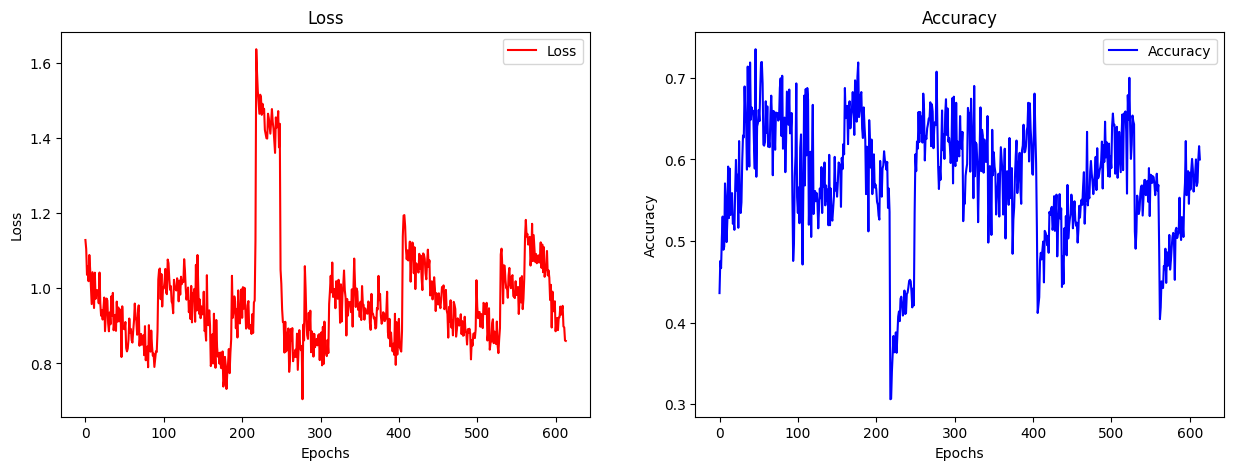

566 0.8599598 0.6


 64%|██████▍   | 32/50 [00:26<00:14,  1.22it/s]


KeyboardInterrupt: 

In [12]:
@tf.function(reduce_retracing=True)
def run(data):
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, strategy.run(tstep, args = (data,)), axis = None)

import IPython


for n in range(1000):
    losses_st = []
    acc_st = []
    for _ in tqdm(range(50)):
    #for _ in range(1000):
        if tpu_mode:
            #distributed_data = (strategy.experimental_distribute_values_from_function(get_data))
            distributed_data = (strategy.experimental_distribute_values_from_function(get_data_2))
            loss, acc = run(distributed_data)
        else:
            data = get_data(None)
            loss, acc = tstep(data)
        losses_st.append(loss)
        acc_st.append(acc)
    
    loss_lt.append(np.mean(losses_st))
    acc_lt.append(np.mean(acc_st))

    
    IPython.display.clear_output()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Loss
    ax1.plot(loss_lt, label="Loss", color="red")
    ax1.set_title("Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

    # Plot Accuracy
    ax2.plot(acc_lt, label="Accuracy", color="blue")
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.show()
    #print(loss_lt, acc_lt)
    print(n, loss_lt[-1], acc_lt[-1])

    #model.save_weights("model.weights.h5")

In [14]:
model.save_weights("model.weights.h5")
